**Chapter 11 – Training Deep Neural Networks**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys 

assert sys.version_info >= (3, 7) # make sure we have Python 3.7+

And TensorFlow >= 2.8:

In [4]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing Exploding Gradients

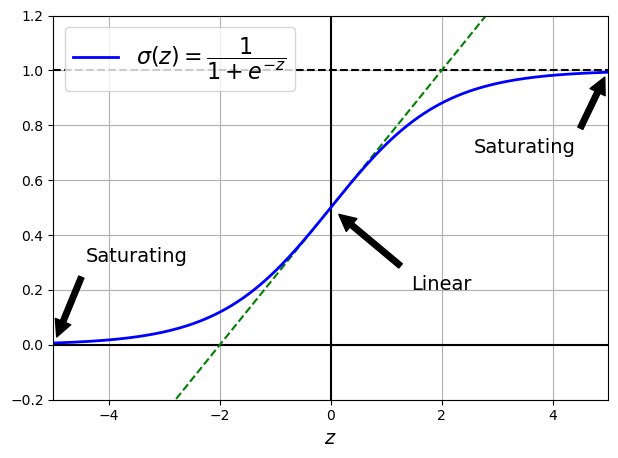

In [8]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [9]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

In [10]:
he_avg_init = tf.initializers.VarianceScaling(scale=2.0, mode="fan_avg", distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

## Nonsaturaing Activaition Functions

### Leaky ReLu

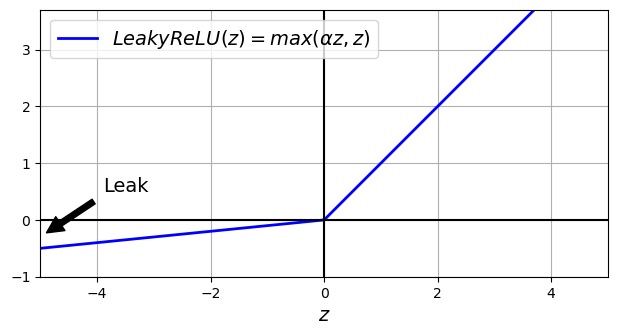

In [11]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [12]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation="leaky_relu", kernel_initializer="he_normal")

In [13]:
model = tf.keras.Sequential([
    # [...] # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(alpha=0.2)            # activation as a separate layer
])

2023-03-16 23:59:35.525542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-16 23:59:35.537345: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 23:59:35.537448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (avtr): /proc/driver/nvidia/version does not exist
2023-03-16 23:59:35.680443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [14]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters(`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1(assuming the inputs are standardzed with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

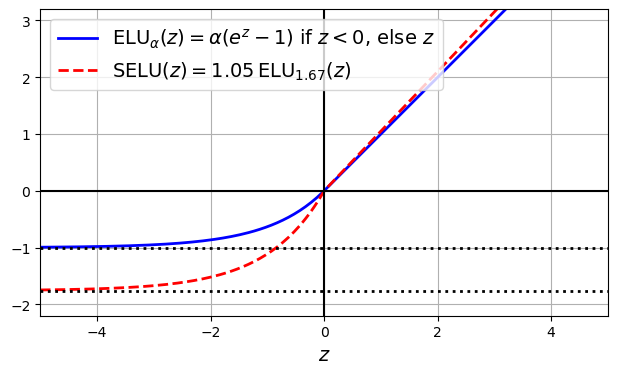

In [15]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [16]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [17]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [19]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [21]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

2023-03-17 00:16:10.392050: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/5
1719/1719 [==============================] - 63s 29ms/step - loss: 1.3029 - accuracy: 0.5157 - val_loss: 0.7982 - val_accuracy: 0.7290
Epoch 2/5
1719/1719 [==============================] - 46s 26ms/step - loss: 0.7259 - accuracy: 0.7446 - val_loss: 0.6047 - val_accuracy: 0.7896
Epoch 3/5
1719/1719 [==============================] - 44s 25ms/step - loss: 0.6045 - accuracy: 0.7880 - val_loss: 0.5424 - val_accuracy: 0.8148
Epoch 4/5
1719/1719 [==============================] - 45s 26ms/step - loss: 0.5519 - accuracy: 0.8104 - val_loss: 0.5348 - val_accuracy: 0.8206
Epoch 5/5
1719/1719 [==============================] - 44s 26ms/step - loss: 0.5068 - accuracy: 0.8268 - val_loss: 0.4879 - val_accuracy: 0.8308


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [24]:
tf.random.set_seed(42)

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [27]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

2023-03-17 00:20:18.549148: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/5
1719/1719 [==============================] - 60s 27ms/step - loss: 2.0095 - accuracy: 0.2316 - val_loss: 1.6322 - val_accuracy: 0.3982
Epoch 2/5
1719/1719 [==============================] - 46s 27ms/step - loss: 1.5927 - accuracy: 0.3644 - val_loss: 1.4281 - val_accuracy: 0.4210
Epoch 3/5
1719/1719 [==============================] - 45s 26ms/step - loss: 1.4038 - accuracy: 0.4179 - val_loss: 1.2362 - val_accuracy: 0.4724
Epoch 4/5
1719/1719 [==============================] - 46s 27ms/step - loss: 1.1090 - accuracy: 0.5333 - val_loss: 0.9680 - val_accuracy: 0.5962
Epoch 5/5
1719/1719 [==============================] - 44s 26ms/step - loss: 0.9264 - accuracy: 0.6161 - val_loss: 0.8191 - val_accuracy: 0.6734


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

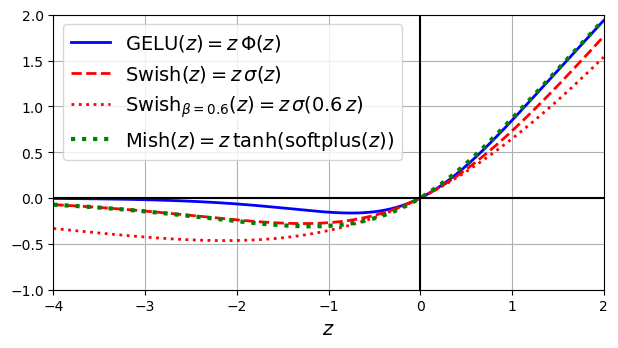

In [28]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

In [29]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", 
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [33]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [34]:
# extra code - just show that the model works!
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid, y_valid))

2023-03-17 00:36:45.478596: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/2
1719/1719 [==============================] - 16s 8ms/step - loss: 0.5552 - accuracy: 0.8073 - val_loss: 1.9017 - val_accuracy: 0.4306
Epoch 2/2
1719/1719 [==============================] - 15s 8ms/step - loss: 0.4116 - accuracy: 0.8530 - val_loss: 2.0105 - val_accuracy: 0.4148


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [35]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [37]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2


2023-03-17 00:38:44.271975: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 13s 7ms/step - loss: 0.6017 - accuracy: 0.7986 - val_loss: 0.4388 - val_accuracy: 0.8410
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4231 - accuracy: 0.8527 - val_loss: 0.3734 - val_accuracy: 0.8638


## Gradient Clipping

All `tf.keras.optimizers` accept clipnorm or `clipvalue` arguments:

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/ tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task 8 classes), and try to reuse it to tackle set B(binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A(trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B(T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convulutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [39]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

2023-03-17 00:53:16.988539: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 138018496 exceeds 10% of free system memory.


Epoch 1/20
1376/1376 [==============================] - 9s 5ms/step - loss: 1.2315 - accuracy: 0.6035 - val_loss: 0.7478 - val_accuracy: 0.7556
Epoch 2/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.6358 - accuracy: 0.7841 - val_loss: 0.5453 - val_accuracy: 0.8070
Epoch 3/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.5082 - accuracy: 0.8279 - val_loss: 0.4650 - val_accuracy: 0.8391
Epoch 4/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.4441 - accuracy: 0.8501 - val_loss: 0.4180 - val_accuracy: 0.8571
Epoch 5/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.4038 - accuracy: 0.8632 - val_loss: 0.3878 - val_accuracy: 0.8636
Epoch 6/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.3754 - accuracy: 0.8727 - val_loss: 0.3645 - val_accuracy: 0.8704
Epoch 7/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3546 - accuracy: 0.8799 - val_loss: 0.3477 - val_accuracy:

INFO:tensorflow:Assets written to: my_model_A/assets


INFO:tensorflow:Assets written to: my_model_A/assets


In [40]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 3s 166ms/step - loss: 0.6685 - accuracy: 0.5800 - val_loss: 0.6652 - val_accuracy: 0.5856
Epoch 2/20
7/7 [==============================] - 0s 40ms/step - loss: 0.6508 - accuracy: 0.6600 - val_loss: 0.6488 - val_accuracy: 0.6370
Epoch 3/20
7/7 [==============================] - 0s 57ms/step - loss: 0.6345 - accuracy: 0.7000 - val_loss: 0.6346 - val_accuracy: 0.6647
Epoch 4/20
7/7 [==============================] - 0s 46ms/step - loss: 0.6187 - accuracy: 0.7350 - val_loss: 0.6205 - val_accuracy: 0.7141
Epoch 5/20
7/7 [==============================] - 0s 63ms/step - loss: 0.6041 - accuracy: 0.7900 - val_loss: 0.6054 - val_accuracy: 0.7705
Epoch 6/20
7/7 [==============================] - 0s 54ms/step - loss: 0.5889 - accuracy: 0.8150 - val_loss: 0.5912 - val_accuracy: 0.8210
Epoch 7/20
7/7 [==============================] - 0s 28ms/step - loss: 0.5741 - accuracy: 0.8550 - val_loss: 0.5772 - val_accuracy: 0.8546
Epoch 8/20
7/7 [==========

[0.44807982444763184, 0.9204999804496765]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [41]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [42]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [43]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [44]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [45]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [46]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 3s 100ms/step - loss: 3.1820 - accuracy: 0.4450 - val_loss: 2.3920 - val_accuracy: 0.4847
Epoch 2/4
7/7 [==============================] - 0s 30ms/step - loss: 2.2314 - accuracy: 0.4450 - val_loss: 1.5597 - val_accuracy: 0.4847
Epoch 3/4
7/7 [==============================] - 0s 27ms/step - loss: 1.4174 - accuracy: 0.4450 - val_loss: 0.9791 - val_accuracy: 0.4540
Epoch 4/4
7/7 [==============================] - 0s 24ms/step - loss: 0.9479 - accuracy: 0.4250 - val_loss: 0.8433 - val_accuracy: 0.3640
Epoch 1/16
7/7 [==============================] - 1s 94ms/step - loss: 0.8091 - accuracy: 0.4150 - val_loss: 0.7468 - val_accuracy: 0.5094
Epoch 2/16
7/7 [==============================] - 0s 22ms/step - loss: 0.7191 - accuracy: 0.5250 - val_loss: 0.6661 - val_accuracy: 0.6518
Epoch 3/16
7/7 [==============================] - 0s 23ms/step - loss: 0.6380 - accuracy: 0.6750 - val_loss: 0.6240 - val_accuracy: 0.6459
Epoch 4/16
7/7 [==============

So, what's the final verdict?

In [47]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.3212 - accuracy: 0.9235


[0.32119280099868774, 0.9235000014305115]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [48]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

# Faster Optimizers

In [49]:
# extra code - a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

In [51]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [52]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6958 - accuracy: 0.7674 - val_loss: 0.5032 - val_accuracy: 0.8142
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4679 - accuracy: 0.8351 - val_loss: 0.4478 - val_accuracy: 0.8438
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4242 - accuracy: 0.8501 - val_loss: 0.4112 - val_accuracy: 0.8526
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3972 - accuracy: 0.8597 - val_loss: 0.3850 - val_accuracy: 0.8604
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3752 - accuracy: 0.8678 - val_loss: 0.3725 - val_accuracy: 0.8662
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3629 - accuracy: 0.8701 - val_loss: 0.3688 - val_accuracy: 0.8676
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3469 - accuracy: 0.8739 - val_loss: 0.3741 - val_accuracy:

## Momentum optimization

In [53]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [54]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.6752 - accuracy: 0.7694 - val_loss: 0.4987 - val_accuracy: 0.8200
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4621 - accuracy: 0.8369 - val_loss: 0.4530 - val_accuracy: 0.8332
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4178 - accuracy: 0.8517 - val_loss: 0.4132 - val_accuracy: 0.8538
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3900 - accuracy: 0.8616 - val_loss: 0.3819 - val_accuracy: 0.8620
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3696 - accuracy: 0.8680 - val_loss: 0.3694 - val_accuracy: 0.8646
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3560 - accuracy: 0.8722 - val_loss: 0.3658 - val_accuracy: 0.8700
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3390 - accuracy: 0.8768 - val_loss: 0.3675 - val_accuracy

## Nesterov Accelerated Gradient

In [55]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [56]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6800 - accuracy: 0.7699 - val_loss: 0.4909 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4588 - accuracy: 0.8383 - val_loss: 0.4391 - val_accuracy: 0.8364
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4170 - accuracy: 0.8527 - val_loss: 0.4075 - val_accuracy: 0.8542
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3919 - accuracy: 0.8618 - val_loss: 0.3854 - val_accuracy: 0.8618
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3711 - accuracy: 0.8685 - val_loss: 0.3697 - val_accuracy: 0.8672
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3566 - accuracy: 0.8735 - val_loss: 0.3915 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3416 - accuracy: 0.8777 - val_loss: 0.3811 - val_accuracy

## AdaGRad

In [57]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [58]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 13s 6ms/step - loss: 0.9642 - accuracy: 0.6999 - val_loss: 0.6571 - val_accuracy: 0.7870
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6193 - accuracy: 0.7951 - val_loss: 0.5645 - val_accuracy: 0.8158
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5566 - accuracy: 0.8154 - val_loss: 0.5258 - val_accuracy: 0.8228
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5249 - accuracy: 0.8251 - val_loss: 0.5039 - val_accuracy: 0.8298
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5043 - accuracy: 0.8300 - val_loss: 0.4889 - val_accuracy: 0.8334
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4895 - accuracy: 0.8344 - val_loss: 0.4791 - val_accuracy: 0.8338
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4782 - accuracy: 0.8377 - val_loss: 0.4681 - val_accuracy

## RMSProp

In [59]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [60]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5134 - accuracy: 0.8143 - val_loss: 0.4851 - val_accuracy: 0.8220
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3934 - accuracy: 0.8583 - val_loss: 0.4250 - val_accuracy: 0.8432
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3655 - accuracy: 0.8687 - val_loss: 0.3768 - val_accuracy: 0.8708
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3549 - accuracy: 0.8766 - val_loss: 0.4007 - val_accuracy: 0.8700
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3494 - accuracy: 0.8770 - val_loss: 0.3748 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3427 - accuracy: 0.8801 - val_loss: 0.4150 - val_accuracy: 0.8666
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3435 - accuracy: 0.8817 - val_loss: 0.3788 - val_accuracy

## Adam Optimization

In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [62]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 13s 6ms/step - loss: 0.4937 - accuracy: 0.8239 - val_loss: 0.4235 - val_accuracy: 0.8318
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3738 - accuracy: 0.8632 - val_loss: 0.3995 - val_accuracy: 0.8426
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3378 - accuracy: 0.8753 - val_loss: 0.3420 - val_accuracy: 0.8764
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3137 - accuracy: 0.8843 - val_loss: 0.3318 - val_accuracy: 0.8792
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2957 - accuracy: 0.8914 - val_loss: 0.3224 - val_accuracy: 0.8822
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2808 - accuracy: 0.8957 - val_loss: 0.3392 - val_accuracy: 0.8792
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2679 - accuracy: 0.8988 - val_loss: 0.3580 - val_accuracy

***Adamax optimization***

In [63]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [64]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 15s 7ms/step - loss: 0.5436 - accuracy: 0.8096 - val_loss: 0.4403 - val_accuracy: 0.8346
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3999 - accuracy: 0.8565 - val_loss: 0.3879 - val_accuracy: 0.8540
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3619 - accuracy: 0.8702 - val_loss: 0.3579 - val_accuracy: 0.8718
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3345 - accuracy: 0.8795 - val_loss: 0.3442 - val_accuracy: 0.8722
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3158 - accuracy: 0.8845 - val_loss: 0.3253 - val_accuracy: 0.8756
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3010 - accuracy: 0.8902 - val_loss: 0.3455 - val_accuracy: 0.8720
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2876 - accuracy: 0.8937 - val_loss: 0.3366 - val_ac

***Nadam Optimization***

In [65]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [66]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 16s 7ms/step - loss: 0.4799 - accuracy: 0.8282 - val_loss: 0.4100 - val_accuracy: 0.8496
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3643 - accuracy: 0.8670 - val_loss: 0.3786 - val_accuracy: 0.8580
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3312 - accuracy: 0.8795 - val_loss: 0.3538 - val_accuracy: 0.8740
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3084 - accuracy: 0.8868 - val_loss: 0.3364 - val_accuracy: 0.8726
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2924 - accuracy: 0.8917 - val_loss: 0.3180 - val_accuracy: 0.8780
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2770 - accuracy: 0.8978 - val_loss: 0.3507 - val_accuracy: 0.8726
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2667 - accuracy: 0.9003 - val_loss: 0.3435 - val_ac

***AdamW Optimization***

On Colab or Kaggle, we need to install the TensorFlow-Addons library:

In [68]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

In [ ]:
history_adamw = build_and_train_model(optimizer)  # extra code

In [ ]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s= 1 / decay`

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

In [ ]:
# extra code – this cell plots power scheduling

import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [74]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [75]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [76]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
# extra code – this cell plots exponential scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [ ]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [ ]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

In [ ]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [78]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [79]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
# extra code – this cell plots piecewise constant scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [ ]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [83]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [84]:
# extra code – build and train the model
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6880 - accuracy: 0.7614 - val_loss: 0.4902 - val_accuracy: 0.8238
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4761 - accuracy: 0.8310 - val_loss: 0.4688 - val_accuracy: 0.8302
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4285 - accuracy: 0.8471 - val_loss: 0.4191 - val_accuracy: 0.8510
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4034 - accuracy: 0.8568 - val_loss: 0.3898 - val_accuracy: 0.8610
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3832 - accuracy: 0.8650 - val_loss: 0.3779 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3678 - accuracy: 0.8693 - val_loss: 0.3948 - val_accuracy: 0.8656
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3576 - accuracy: 0.8725 - val_loss: 0.3753 - val_accurac

For piecewise constant scheduling, try this:

In [ ]:
# extra code – shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [86]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [87]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [88]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [89]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [91]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [92]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 6s 7ms/step - loss: 0.9634 - accuracy: 0.6839 - val_loss: 0.6035 - val_accuracy: 0.7926
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.5799 - accuracy: 0.7970 - val_loss: 0.4965 - val_accuracy: 0.8264
Epoch 3/25
430/430 [==============================] - 3s 7ms/step - loss: 0.5000 - accuracy: 0.8229 - val_loss: 0.4650 - val_accuracy: 0.8330
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4526 - accuracy: 0.8391 - val_loss: 0.4346 - val_accuracy: 0.8444
Epoch 5/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4222 - accuracy: 0.8494 - val_loss: 0.4105 - val_accuracy: 0.8508
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3964 - accuracy: 0.8586 - val_loss: 0.4758 - val_accuracy: 0.8252
Epoch 7/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3823 - accuracy: 0.8614 - val_loss: 0.3802 - val_accuracy: 0.8628
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [93]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [94]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [95]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [96]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 6ms/step - loss: 3.1368 - accuracy: 0.7694 - val_loss: 1.8638 - val_accuracy: 0.8206
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 1.4291 - accuracy: 0.8127 - val_loss: 1.1318 - val_accuracy: 0.8140


# Dropout

In [97]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [99]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 7ms/step - loss: 0.6787 - accuracy: 0.7508 - val_loss: 0.4391 - val_accuracy: 0.8402
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5085 - accuracy: 0.8139 - val_loss: 0.4076 - val_accuracy: 0.8462
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4737 - accuracy: 0.8273 - val_loss: 0.4034 - val_accuracy: 0.8496
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4525 - accuracy: 0.8341 - val_loss: 0.4011 - val_accuracy: 0.8492
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4316 - accuracy: 0.8404 - val_loss: 0.3685 - val_accuracy: 0.8650
Epoch 6/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.4239 - accuracy: 0.8430 - val_loss: 0.3683 - val_accuracy: 0.8640
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4153 - accuracy: 0.8467 - val_loss: 0.3568 - val_accur

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [100]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3080 - accuracy: 0.8860


[0.3079697787761688, 0.8859817981719971]

In [101]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3648 - accuracy: 0.8684


[0.3647719919681549, 0.868399977684021]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout

In [102]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [103]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [104]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 2s 2s/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.006, 0.   , 0.317, 0.   ,
        0.677]], dtype=float32)

In [105]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.015, 0.   , 0.294, 0.002,
       0.687], dtype=float32)

In [106]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.001, 0.001, 0.001, 0.002, 0.001, 0.02 , 0.001, 0.179, 0.013,
       0.186], dtype=float32)

In [107]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8675

In [108]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [109]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [110]:
mc_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_81 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_82 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_83 (Dense)            (None, 10)              

Now we can use the model with MC Dropout:

In [111]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 32ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.28, 0.  , 0.7 ]],
      dtype=float32)